In [3]:
#### import cv2
from scipy.ndimage import distance_transform_edt as dist
import IPython.display 
import importlib
import skimage.io as imgio
import numpy as np
import os
import torch
import torch.nn.functional as F
import math
import re
from matplotlib import pyplot as plt
from scipy import ndimage
from topoloss4neurons.networks import UNet
import networktraining as nt
import os
import tifffile
import skimage
from utils import getCube, findCubes, getCubeCoords, loadTahaPred
from tqdm import tqdm
%matplotlib inline
# %matplotlib notebook

In [14]:
xs,ys,zs = getCubeCoords(244)
x,y,z = [13, 34, 1]
(ys[y]*10,xs[x]*10,zs[z]*10)

(86080, 32810, 2500)

"/home/oner/samba/TeraConvertion/AL244_tera/RES(14680x16385x1998)" --> data
"/cvlabdata1/home/zakariya/CarlsData/AL244" -> preds

In [26]:
def create_processed_cube_list(brain_i, path):

    cubes = []
    xs,ys,zs = getCubeCoords(brain_i)
    
    for folder_y in os.listdir(path):
        for folder_x in os.listdir(f'{path}/{folder_y}'):
            for file_yxz in os.listdir(f'{path}/{folder_y}/{folder_x}'):
                
                y = int(folder_y)//10
                x = int(folder_x.split("_")[-1])//10
                z = int(file_yxz.split("_")[-1][:-4])//10
                
                y = np.where(np.array(ys)==y)[0][0]
                x = np.where(np.array(xs)==x)[0][0]
                z = np.where(np.array(zs)==z)[0][0]
                
                cubes.append([x,y,z])
    
    return cubes

In [5]:
cubes = create_processed_cube_list(244, "/cvlabdata1/home/zakariya/CarlsData/AL244")

In [7]:
def createGray_clip_expo(im, pred, lmbd=0.5):
    # clipping ...
    
    pred = np.clip(pred, a_min=pred.min(), a_max=6)
    pred = (pred.max() - pred)/pred.max()
    pred = np.power(pred, 2)
    pred /= pred.max()
    
    tmp = im.max()
    im = (im / im.max() * 255).astype(np.uint8)
    
    finalim = ((lmbd*pred*255) + im)
    finalim /= finalim.max()/tmp

    return finalim.astype(np.int16)

def createRGB_clip_expo(im, pred, lmbd=0.5):
    
    g_channel = np.clip(pred, a_min=pred.min(), a_max=6)
    g_channel = np.array((g_channel.max() - g_channel)/g_channel.max())
    g_channel = np.power(g_channel, 2)
    g_channel /= g_channel.max()
    
    
    finalim = np.zeros((im.shape[0], im.shape[1], im.shape[2], 3))
    finalim[:,:,:,0] = im.astype(np.int16)
    finalim[:,:,:,2] = im.astype(np.int16)
    finalim[:,:,:,1] = (g_channel * 65535 * 0.8).astype(np.int16)
    
    return finalim.astype(np.int16)


def createGray(im, pred, lmbd=0.5):
    # clipping ...
    pred = (pred.max() - pred)/pred.max()
    tmp = im.max()
    im = (im / im.max() * 255).astype(np.uint8)
    
    finalim = ((lmbd*pred*255) + im)
    finalim /= finalim.max()/tmp

    return finalim.astype(np.int16)

In [8]:
dims = np.array(cubes).max(0) - np.array(cubes).min(0) +1
maxs = np.array(cubes).max(0)
mins = np.array(cubes).min(0)

In [9]:
cubes

[[11, 35, 2],
 [11, 35, 1],
 [11, 35, 0],
 [10, 35, 2],
 [10, 35, 1],
 [12, 35, 2],
 [12, 35, 1],
 [12, 35, 0],
 [9, 35, 2],
 [9, 35, 1],
 [13, 35, 2],
 [13, 35, 1],
 [13, 35, 0],
 [14, 35, 2],
 [14, 35, 0],
 [14, 35, 1],
 [8, 35, 1],
 [8, 35, 2],
 [15, 35, 2],
 [15, 35, 1],
 [15, 35, 0],
 [7, 35, 1],
 [7, 35, 2],
 [6, 35, 1],
 [16, 35, 1],
 [17, 35, 1],
 [21, 35, 0],
 [22, 35, 0],
 [23, 35, 0],
 [11, 36, 2],
 [11, 36, 1],
 [11, 36, 0],
 [10, 36, 2],
 [10, 36, 1],
 [9, 36, 2],
 [9, 36, 1],
 [8, 36, 2],
 [14, 36, 2],
 [14, 36, 1],
 [14, 36, 0],
 [12, 36, 1],
 [12, 36, 0],
 [15, 36, 2],
 [15, 36, 1],
 [13, 36, 1],
 [13, 36, 0],
 [16, 36, 1],
 [17, 36, 1],
 [19, 36, 0],
 [20, 36, 0],
 [21, 36, 0],
 [10, 34, 2],
 [10, 34, 1],
 [9, 34, 2],
 [9, 34, 1],
 [8, 34, 2],
 [11, 34, 1],
 [11, 34, 2],
 [7, 34, 2],
 [7, 34, 1],
 [12, 34, 1],
 [12, 34, 0],
 [13, 34, 1],
 [13, 34, 0],
 [14, 34, 1],
 [14, 34, 0],
 [15, 34, 1],
 [16, 34, 1],
 [17, 34, 1],
 [18, 34, 1],
 [22, 34, 0],
 [23, 34, 0],
 [10, 3

# Segmenting

In [10]:
#############    To change if not brain 175     #############
direc = "/cvlabdata1/home/zakariya/CarlsData/AL244"

##### Test if works with 1 (pb with direc not run + didn't find getCoords)

In [11]:
brain_i = 244

In [15]:
xs,ys,zs = getCubeCoords(brain_i)
im = np.float32(getCube(brain_i, [14, 35, 1]))
pred_np = loadTahaPred(brain_i, [14, 35, 1])
x,y,z = [14, 35, 1]
l1 = "{:06d}".format(ys[y]*10)
l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
l3 = "{:06d}_{:06d}_{:06d}.tif".format(ys[y]*10,xs[x]*10,zs[z]*10)

#path = os.path.join(direc,l1,l2,l3)
#os.rename(path, f'{path}_old')

rgb_pred = createGray_clip_expo(im, pred_np)
tifffile.imsave(os.path.join(direc,l1,l2,l3), rgb_pred)

In [16]:
direc = "/cvlabdata1/home/zakariya/CarlsData/AL244"

# keep mins/maxs or indexes of seg cubes

def segment_cubes(brain_i, direc):
    
    cubes = create_processed_cube_list(brain_i, direc)
    dims = np.array(cubes).max(0) - np.array(cubes).min(0) +1
    maxs = np.array(cubes).max(0)
    mins = np.array(cubes).min(0)
    xs,ys,zs = getCubeCoords(brain_i)
    
    for i in tqdm(range(mins[0],maxs[0]+1)):
        for j in range(mins[1],maxs[1]+1):
            for k in range(mins[2],maxs[2]+1):
                
                print(i,j,k)
                im = np.float32(getCube(brain_i, [i,j,k]))
                try:# if it is segmented load the prediction
                    pred_np = loadTahaPred(brain_i, [i,j,k])

                    x,y,z = [i,j,k]
                    l1 = "{:06d}".format(ys[y]*10)
                    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
                    l3 = "{:06d}_{:06d}_{:06d}.tif".format(ys[y]*10,xs[x]*10,zs[z]*10)
                    #rename old image with prediction

                    #path = os.path.join(direc,l1,l2,l3)
                    #os.rename(path, f'{path}_old') --> no need to rename

                    #create the prediction to save
                    rgb_pred = createGray_clip_expo(im, pred_np)
                    #nt.utils.mkdir(os.path.join(direc,l1,l2))
                    tifffile.imsave(os.path.join(direc,l1,l2,l3), rgb_pred)
                    
                    print("Loaded and file name changed")
                except: # if it is an empty cube just put all 15 (because the highest value in distance map is 15)
                    pred_np = 15*np.ones(im.shape)              

In [27]:
segment_cubes(brain_i, "/cvlabdata1/home/zakariya/CarlsData/AL244")

  0%|                                                    | 0/18 [00:00<?, ?it/s]

6 28 0
6 28 1
6 28 2
6 29 0
6 29 1
6 29 2
6 30 0
6 30 1
6 30 2
6 31 0
6 31 1
6 31 2
6 32 0
6 32 1
6 32 2
6 33 0
6 33 1
6 33 2
6 34 0
6 34 1
6 34 2
6 35 0
6 35 1
Loaded and file name changed
6 35 2
6 36 0
6 36 1
6 36 2
6 37 0
6 37 1
6 37 2
6 38 0
6 38 1
6 38 2
6 39 0
6 39 1
6 39 2
6 40 0
6 40 1
6 40 2
6 41 0
6 41 1
6 41 2
6 42 0
6 42 1
6 42 2
6 43 0
6 43 1
6 43 2


  6%|██▍                                         | 1/18 [01:30<25:44, 90.83s/it]

7 28 0
7 28 1
7 28 2
7 29 0
7 29 1
7 29 2
7 30 0
7 30 1
7 30 2
7 31 0
7 31 1
7 31 2
7 32 0
7 32 1
7 32 2
7 33 0
7 33 1
7 33 2
7 34 0
7 34 1


/cvlabdata2/home/zakariya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Loaded and file name changed
7 34 2
Loaded and file name changed
7 35 0
7 35 1
Loaded and file name changed
7 35 2
Loaded and file name changed
7 36 0
7 36 1
7 36 2
7 37 0
7 37 1
7 37 2
7 38 0
7 38 1
7 38 2
Loaded and file name changed
7 39 0
7 39 1
7 39 2
7 40 0
7 40 1
7 40 2
7 41 0
7 41 1
7 41 2
7 42 0
7 42 1
7 42 2
7 43 0
7 43 1
7 43 2


 11%|████▉                                       | 2/18 [03:07<24:41, 92.59s/it]

8 28 0
8 28 1
8 28 2
8 29 0
8 29 1
8 29 2
8 30 0
8 30 1
8 30 2
8 31 0
8 31 1
8 31 2
8 32 0
8 32 1
8 32 2
8 33 0
8 33 1
8 33 2
Loaded and file name changed
8 34 0
8 34 1
8 34 2
Loaded and file name changed
8 35 0
8 35 1
Loaded and file name changed
8 35 2
9 31 1
9 31 1
9 31 2
9 31 2
9 32 0
9 32 0
9 32 1
9 32 1
9 32 2
9 32 2
9 33 0
9 33 0
9 33 1
9 33 1
Loaded and file name changed
9 33 2
Loaded and file name changed
9 33 2
9 34 0
9 34 0
9 34 1
9 34 1
Loaded and file name changed
9 34 2
Loaded and file name changed
9 34 2
Loaded and file name changed
9 35 0
Loaded and file name changed
9 35 0
9 35 1
9 35 1
Loaded and file name changed
9 35 2
Loaded and file name changed
9 35 2
Loaded and file name changed
9 36 0
Loaded and file name changed
9 36 0
9 36 1
9 36 1
Loaded and file name changed
9 36 2
Loaded and file name changed
9 36 2
Loaded and file name changed
9 37 0
Loaded and file name changed
9 37 0
9 37 1
9 37 1
Loaded and file name changed
9 37 2
Loaded and file name changed
9 37 2
L

 33%|██████████████▎                            | 6/18 [10:36<21:39, 108.32s/it]

12 28 0
12 28 1
Loaded and file name changed
12 28 2
12 29 0
12 29 1
Loaded and file name changed
12 29 2
12 30 0
12 30 1
Loaded and file name changed
12 30 2
12 31 0
Loaded and file name changed
12 31 1
Loaded and file name changed
12 31 2
12 32 0
Loaded and file name changed
12 32 1
Loaded and file name changed
12 32 2
Loaded and file name changed
12 33 0
Loaded and file name changed
12 33 1
Loaded and file name changed
12 33 2
Loaded and file name changed
12 34 0
Loaded and file name changed
12 34 1
Loaded and file name changed
12 34 2
12 35 0
Loaded and file name changed
12 35 1
Loaded and file name changed
12 35 2
Loaded and file name changed
12 36 0
Loaded and file name changed
12 36 1
Loaded and file name changed
12 36 2
12 37 0
Loaded and file name changed
12 37 1
Loaded and file name changed
12 37 2
12 38 0
12 38 1
Loaded and file name changed
12 38 2
12 39 0
12 39 1
Loaded and file name changed
12 39 2
12 40 0
12 40 1
12 40 2
12 41 0
12 41 1
12 41 2
12 42 0
12 42 1
12 42 2
12

 39%|████████████████▋                          | 7/18 [12:40<20:42, 112.98s/it]

13 28 0
13 28 1
Loaded and file name changed
13 28 2
13 29 0
13 29 1
Loaded and file name changed
13 29 2
13 30 0
13 30 1
Loaded and file name changed
13 30 2
13 31 0
Loaded and file name changed
13 31 1
13 31 2
13 32 0
13 32 1
Loaded and file name changed
13 32 2
Loaded and file name changed
13 33 0
Loaded and file name changed
13 33 1
Loaded and file name changed
13 33 2
13 34 0
Loaded and file name changed
13 34 1
Loaded and file name changed
13 34 2
13 35 0
Loaded and file name changed
13 35 1
Loaded and file name changed
13 35 2
Loaded and file name changed
13 36 0
Loaded and file name changed
13 36 1
Loaded and file name changed
13 36 2
13 37 0
13 37 1
Loaded and file name changed
13 37 2
13 38 0
13 38 1
Loaded and file name changed
13 38 2
13 39 0
13 39 1
Loaded and file name changed
13 39 2
13 40 0
13 40 1
13 40 2
13 41 0
13 41 1
13 41 2
13 42 0
13 42 1
13 42 2
13 43 0
13 43 1
13 43 2


 44%|███████████████████                        | 8/18 [14:41<19:16, 115.62s/it]

14 28 0
14 28 1
14 28 2
14 29 0
14 29 1
14 29 2
14 30 0
14 30 1
14 30 2
14 31 0
14 31 1
14 31 2
14 32 0
14 32 1
14 32 2
14 33 0
14 33 1
14 33 2
14 34 0
Loaded and file name changed
14 34 1
Loaded and file name changed
14 34 2
14 35 0
Loaded and file name changed
14 35 1
Loaded and file name changed
14 35 2
Loaded and file name changed
14 36 0
Loaded and file name changed
14 36 1
Loaded and file name changed
14 36 2
Loaded and file name changed
14 37 0
14 37 1
Loaded and file name changed
14 37 2
14 38 0
14 38 1
Loaded and file name changed
14 38 2
14 39 0
14 39 1
Loaded and file name changed
14 39 2
14 40 0
14 40 1
14 40 2
14 41 0
14 41 1
14 41 2
14 42 0
14 42 1
14 42 2
14 43 0
14 43 1
14 43 2


 50%|█████████████████████▌                     | 9/18 [16:37<17:20, 115.60s/it]

15 28 0
15 28 1
15 28 2
15 29 0
15 29 1
15 29 2
15 30 0
15 30 1
15 30 2
15 31 0
15 31 1
15 31 2
15 32 0
15 32 1
15 32 2
15 33 0
15 33 1
15 33 2
15 34 0
15 34 1
Loaded and file name changed
15 34 2
15 35 0
Loaded and file name changed
15 35 1
Loaded and file name changed
15 35 2
Loaded and file name changed
15 36 0
15 36 1
Loaded and file name changed
15 36 2
Loaded and file name changed
15 37 0
15 37 1
Loaded and file name changed
15 37 2
15 38 0
15 38 1
Loaded and file name changed
15 38 2
15 39 0
15 39 1
Loaded and file name changed
15 39 2
15 40 0
15 40 1
15 40 2
15 41 0
15 41 1
15 41 2
15 42 0
15 42 1
15 42 2
15 43 0
15 43 1
15 43 2


 56%|███████████████████████▎                  | 10/18 [18:32<15:22, 115.27s/it]

16 28 0
16 28 1
16 28 2
16 29 0
16 29 1
16 29 2
16 30 0
16 30 1
16 30 2
16 31 0
16 31 1
16 31 2
16 32 0
16 32 1
16 32 2
16 33 0
16 33 1
16 33 2
16 34 0
16 34 1
Loaded and file name changed
16 34 2
16 35 0
16 35 1
Loaded and file name changed
16 35 2
16 36 0
16 36 1
Loaded and file name changed
16 36 2
16 37 0
16 37 1
Loaded and file name changed
16 37 2
16 38 0
16 38 1
16 38 2
16 39 0
16 39 1
16 39 2
16 40 0
16 40 1
16 40 2
16 41 0
16 41 1
16 41 2
16 42 0
16 42 1
16 42 2
16 43 0
16 43 1
16 43 2


 61%|█████████████████████████▋                | 11/18 [20:22<13:17, 113.92s/it]

17 28 0
17 28 1
17 28 2
17 29 0
17 29 1
17 29 2
17 30 0
17 30 1
17 30 2
17 31 0
17 31 1
17 31 2
17 32 0
17 32 1
17 32 2
17 33 0
17 33 1
17 33 2
17 34 0
17 34 1
Loaded and file name changed
17 34 2
17 35 0
17 35 1
Loaded and file name changed
17 35 2
17 36 0
17 36 1
Loaded and file name changed
17 36 2
17 37 0
Loaded and file name changed
17 37 1
Loaded and file name changed
17 37 2
17 38 0
17 38 1
17 38 2
17 39 0
17 39 1
17 39 2
17 40 0
17 40 1
17 40 2
17 41 0
17 41 1
17 41 2
17 42 0
17 42 1
17 42 2
17 43 0
17 43 1
17 43 2


 67%|████████████████████████████              | 12/18 [22:13<11:17, 112.87s/it]

18 28 0
18 28 1
18 28 2
18 29 0
18 29 1
18 29 2
18 30 0
18 30 1
18 30 2
18 31 0
18 31 1
18 31 2
18 32 0
18 32 1
18 32 2
18 33 0
18 33 1
18 33 2
18 34 0
18 34 1
Loaded and file name changed
18 34 2
18 35 0
18 35 1
18 35 2
18 36 0
18 36 1
18 36 2
18 37 0
Loaded and file name changed
18 37 1
Loaded and file name changed
18 37 2
18 38 0
18 38 1
18 38 2
18 39 0
18 39 1
18 39 2
18 40 0
18 40 1
18 40 2
18 41 0
18 41 1
18 41 2
18 42 0
18 42 1
18 42 2
18 43 0
18 43 1
18 43 2


 72%|██████████████████████████████▎           | 13/18 [24:03<09:20, 112.08s/it]

19 28 0
19 28 1
19 28 2
19 29 0
19 29 1
19 29 2
19 30 0
19 30 1
19 30 2
19 31 0
19 31 1
19 31 2
19 32 0
19 32 1
19 32 2
19 33 0
19 33 1
19 33 2
19 34 0
19 34 1
19 34 2
19 35 0
19 35 1
19 35 2
19 36 0
Loaded and file name changed
19 36 1
19 36 2
19 37 0
Loaded and file name changed
19 37 1
Loaded and file name changed
19 37 2
19 38 0
Loaded and file name changed
19 38 1
19 38 2
19 39 0
19 39 1
19 39 2
19 40 0
19 40 1
19 40 2
19 41 0
19 41 1
19 41 2
19 42 0
19 42 1
19 42 2
19 43 0
19 43 1
19 43 2


 78%|████████████████████████████████▋         | 14/18 [25:53<07:26, 111.59s/it]

20 28 0
20 28 1
20 28 2
20 29 0
20 29 1
20 29 2
20 30 0
20 30 1
20 30 2
20 31 0
20 31 1
20 31 2
20 32 0
20 32 1
20 32 2
20 33 0
20 33 1
20 33 2
20 34 0
20 34 1
20 34 2
20 35 0
20 35 1
20 35 2
20 36 0
Loaded and file name changed
20 36 1
20 36 2
20 37 0
Loaded and file name changed
20 37 1
20 37 2
20 38 0
Loaded and file name changed
20 38 1
20 38 2
20 39 0
20 39 1
20 39 2
20 40 0
20 40 1
20 40 2
20 41 0
20 41 1
20 41 2
20 42 0
20 42 1
20 42 2
20 43 0
20 43 1
20 43 2


 83%|███████████████████████████████████       | 15/18 [27:43<05:32, 110.94s/it]

21 28 0
21 28 1
21 28 2
21 29 0
21 29 1
21 29 2
21 30 0
21 30 1
21 30 2
21 31 0
21 31 1
21 31 2
21 32 0
21 32 1
21 32 2
21 33 0
21 33 1
21 33 2
21 34 0
21 34 1
21 34 2
21 35 0
Loaded and file name changed
21 35 1
21 35 2
21 36 0
Loaded and file name changed
21 36 1
21 36 2
21 37 0
Loaded and file name changed
21 37 1
21 37 2
21 38 0
21 38 1
21 38 2
21 39 0
21 39 1
21 39 2
21 40 0
21 40 1
21 40 2
21 41 0
21 41 1
21 41 2
21 42 0
21 42 1
21 42 2
21 43 0
21 43 1
21 43 2


 89%|█████████████████████████████████████▎    | 16/18 [29:33<03:41, 110.71s/it]

22 28 0
22 28 1
22 28 2
22 29 0
22 29 1
22 29 2
22 30 0
22 30 1
22 30 2
22 31 0
22 31 1
22 31 2
22 32 0
22 32 1
22 32 2
22 33 0
22 33 1
22 33 2
22 34 0
Loaded and file name changed
22 34 1
22 34 2
22 35 0
Loaded and file name changed
22 35 1
22 35 2
22 36 0
22 36 1
22 36 2
22 37 0
22 37 1
22 37 2
22 38 0
22 38 1
22 38 2
22 39 0
22 39 1
22 39 2
22 40 0
22 40 1
22 40 2
22 41 0
22 41 1
22 41 2
22 42 0
22 42 1
22 42 2
22 43 0
22 43 1
22 43 2


 94%|███████████████████████████████████████▋  | 17/18 [31:22<01:50, 110.09s/it]

23 28 0
23 28 1
23 28 2
23 29 0
23 29 1
23 29 2
23 30 0
23 30 1
23 30 2
23 31 0
23 31 1
23 31 2
23 32 0
23 32 1
23 32 2
23 33 0
Loaded and file name changed
23 33 1
23 33 2
23 34 0
Loaded and file name changed
23 34 1
23 34 2
23 35 0
Loaded and file name changed
23 35 1
23 35 2
23 36 0
23 36 1
23 36 2
23 37 0
23 37 1
23 37 2
23 38 0
23 38 1
23 38 2
23 39 0
23 39 1
23 39 2
23 40 0
23 40 1
23 40 2
23 41 0
23 41 1
23 41 2
23 42 0
23 42 1
23 42 2
23 43 0
23 43 1
23 43 2


100%|██████████████████████████████████████████| 18/18 [33:12<00:00, 110.69s/it]


# Tests

In [27]:
cube_i = [17, 34, 0]

In [28]:
t = getCube(brain_i, cube_i)/65535
t = t*255

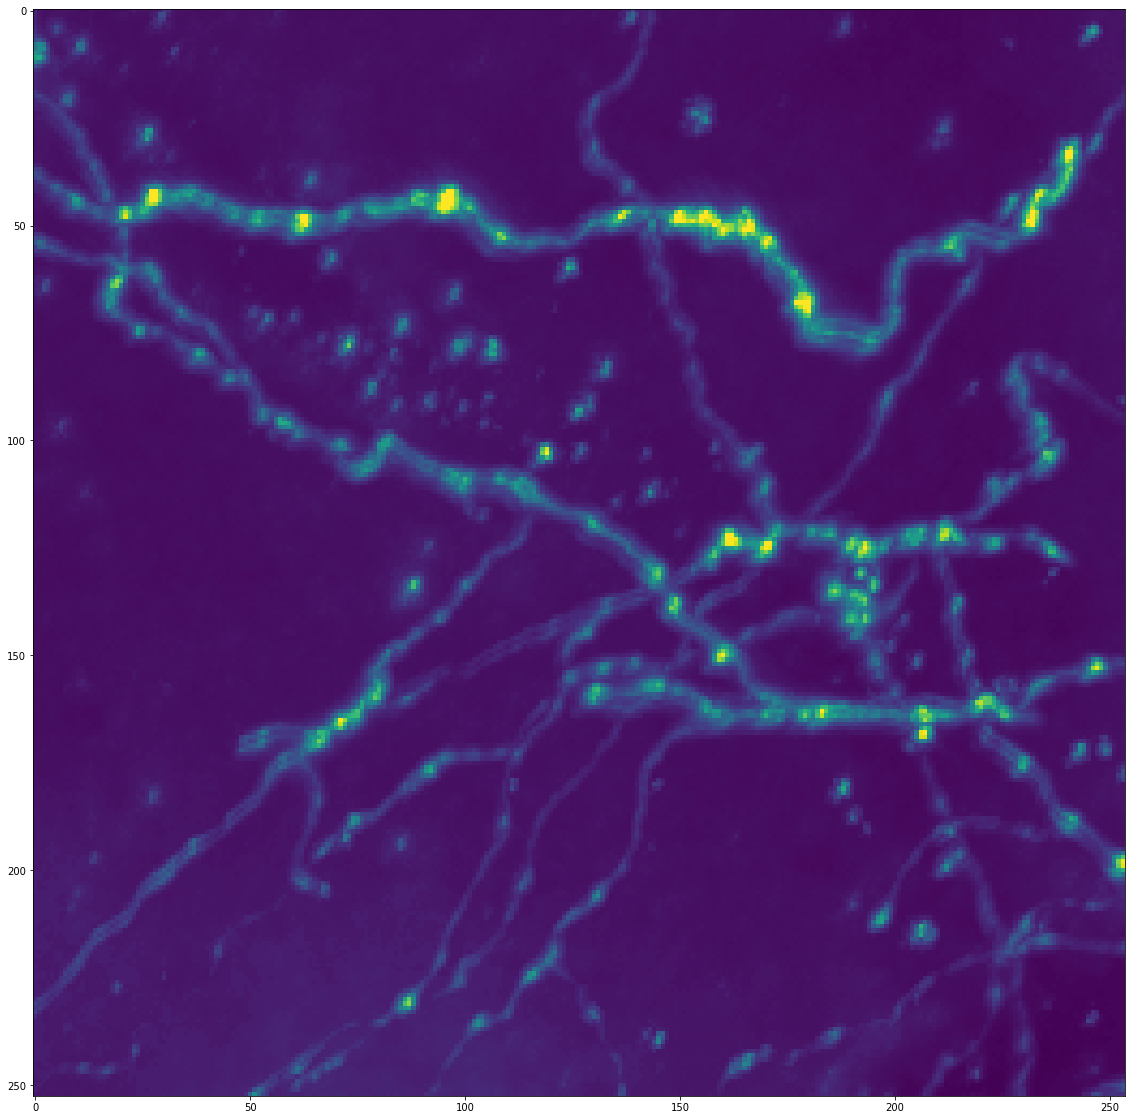

In [29]:
plt.figure(figsize=(20,20))
plt.imshow(t.astype('uint8').max(2))

In [44]:
cubes

[[13, 34, 1],
 [13, 34, 0],
 [13, 34, 2],
 [13, 34, 1],
 [13, 34, 0],
 [13, 34, 2],
 [12, 34, 1],
 [12, 34, 2],
 [12, 34, 1],
 [12, 34, 2],
 [14, 34, 1],
 [14, 34, 0],
 [14, 34, 2],
 [14, 34, 0],
 [14, 34, 1],
 [14, 34, 2],
 [11, 34, 1],
 [11, 34, 1],
 [15, 34, 1],
 [15, 34, 0],
 [15, 34, 2],
 [15, 34, 0],
 [15, 34, 1],
 [15, 34, 2],
 [16, 34, 1],
 [16, 34, 0],
 [16, 34, 0],
 [16, 34, 1],
 [17, 34, 1],
 [17, 34, 0],
 [17, 34, 0],
 [17, 34, 1],
 [18, 34, 1],
 [18, 34, 0],
 [18, 34, 2],
 [18, 34, 0],
 [18, 34, 1],
 [18, 34, 2],
 [19, 34, 1],
 [19, 34, 0],
 [19, 34, 2],
 [19, 34, 0],
 [19, 34, 1],
 [19, 34, 2],
 [20, 34, 1],
 [20, 34, 1],
 [21, 34, 1],
 [21, 34, 0],
 [21, 34, 0],
 [21, 34, 1],
 [22, 34, 1],
 [22, 34, 1],
 [23, 34, 1],
 [23, 34, 1],
 [24, 34, 1],
 [24, 34, 1],
 [25, 34, 1],
 [25, 34, 1],
 [26, 34, 1],
 [26, 34, 1],
 [27, 34, 1],
 [27, 34, 1],
 [28, 34, 1],
 [28, 34, 1],
 [29, 34, 1],
 [29, 34, 1],
 [30, 34, 1],
 [30, 34, 1],
 [31, 34, 1],
 [31, 34, 2],
 [31, 34, 1],
 [31, 

In [31]:
im1 = getCube(brain_i, cube_i)
pred1 = loadTahaPred(brain_i, cube_i)

rgb_pred1 = createRGB_clip_expo(im1, pred1)
tifffile.imsave('/cvlabdata2/home/zakariya/cube_test.tif', rgb_pred1)

In [32]:
rgb_pred1 = rgb_pred1/rgb_pred1.max()
#rgb_pred1 = rgb_pred1*255
#rgb_pred1 = rgb_pred1.astype(np.int16)

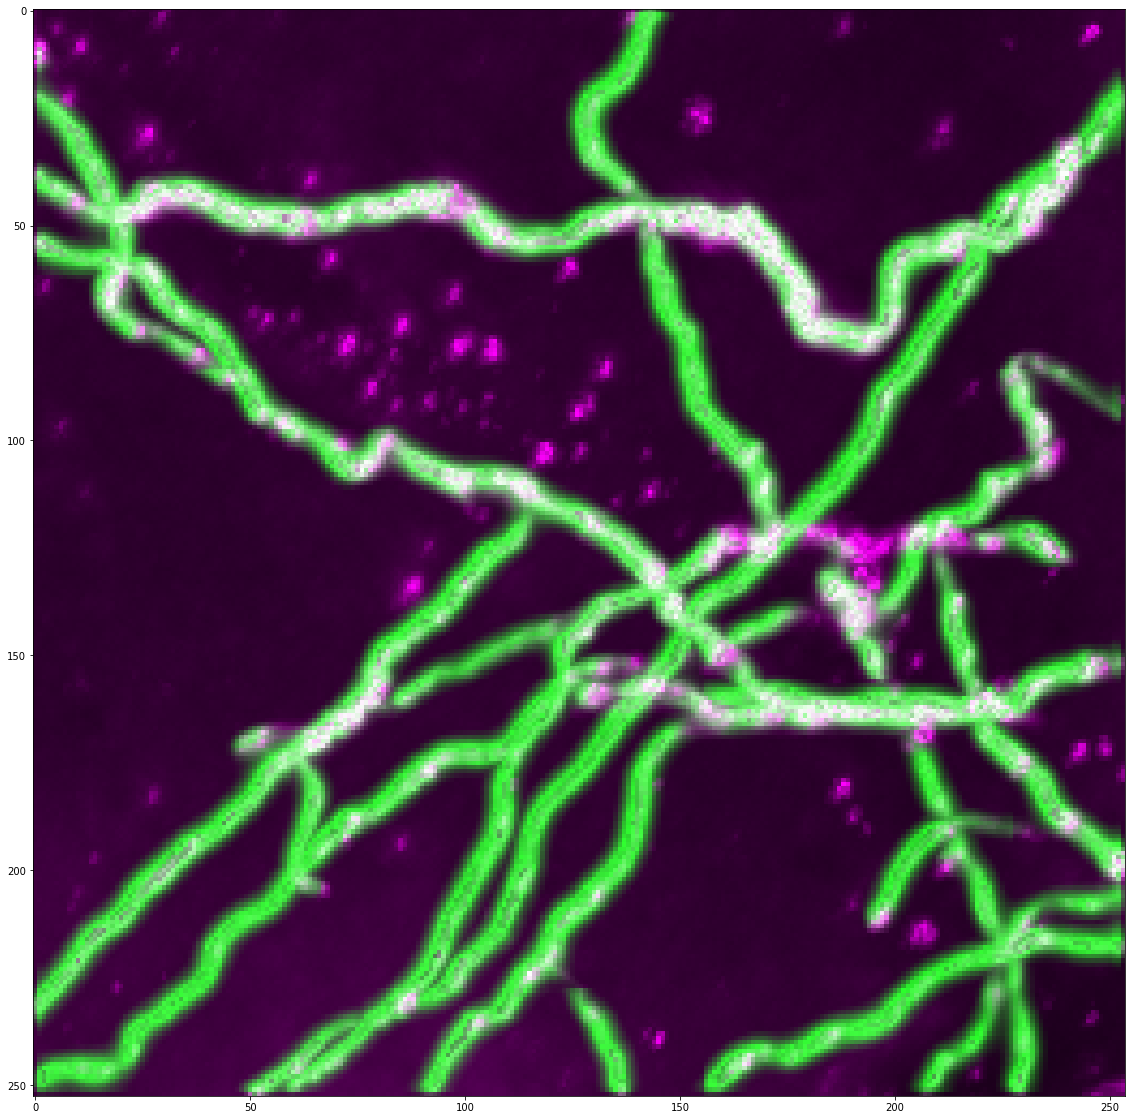

In [33]:
plt.figure(figsize=(20,20))
plt.imshow(rgb_pred1.max(2))

## Grayscale

In [34]:
def create_grayscale_plot(brain_i, cube):
    pred = createGray_clip_expo(getCube(brain_i, cube), loadTahaPred(brain_i, cube))
    pred = pred/pred.max()
    
    im = getCube(brain_i, cube)/65535
    im = im*255
    
    
    return im.astype('uint8').max(2), pred.max(2)

#### Grayscale basic

In [35]:
rgb_im_gray_basic = createGray(getCube(brain_i, cube_i), loadTahaPred(brain_i, cube_i))

In [36]:
rgb_im_gray_basic = rgb_im_gray_basic/rgb_im_gray_basic.max()

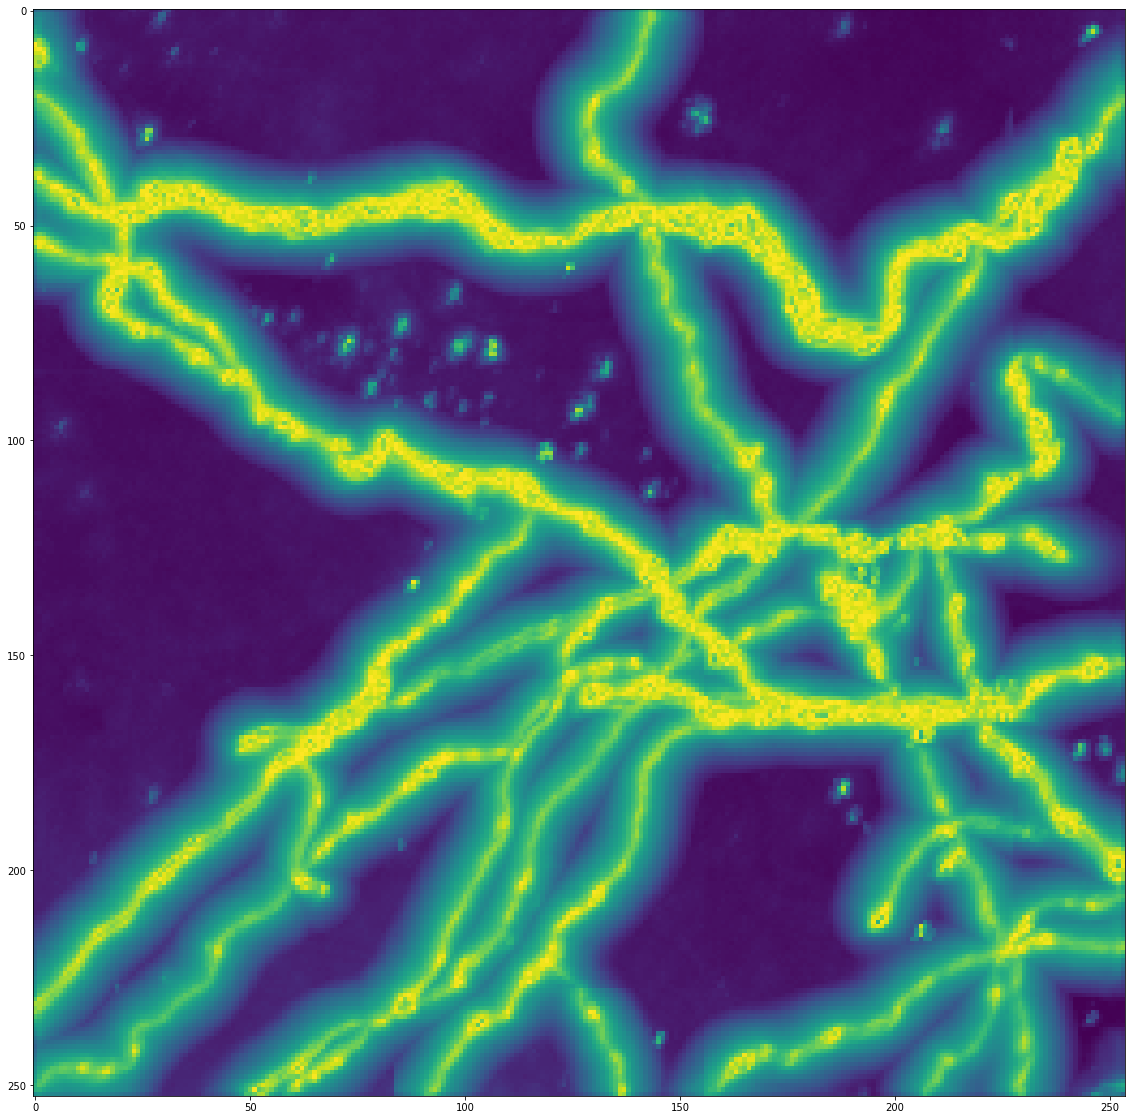

In [37]:
plt.figure(figsize=(20,20))
plt.imshow(rgb_im_gray_basic.max(2))

#### Grayscale clip_expo

In [38]:
rgb_im_gray = createGray_clip_expo(getCube(brain_i, cube_i), loadTahaPred(brain_i, cube_i))

In [39]:
rgb_im_gray = rgb_im_gray/rgb_im_gray.max()

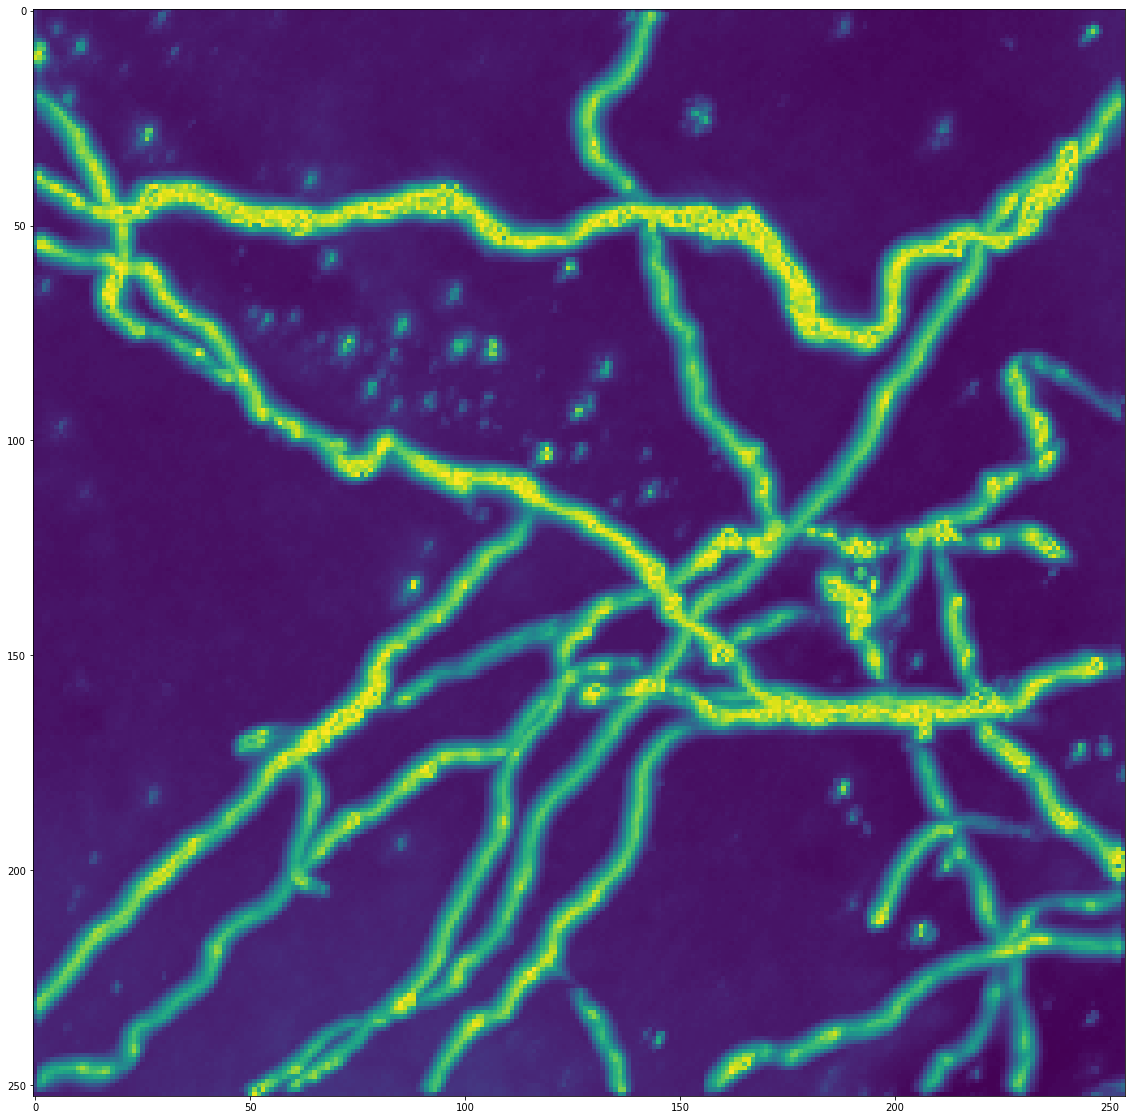

In [40]:
plt.figure(figsize=(20,20))
plt.imshow(rgb_im_gray.max(2))

# Comparison plots

In [41]:
predss = []
predss.append(t)
predss.append(rgb_pred1)
predss.append(rgb_im_gray)

len(predss)

3

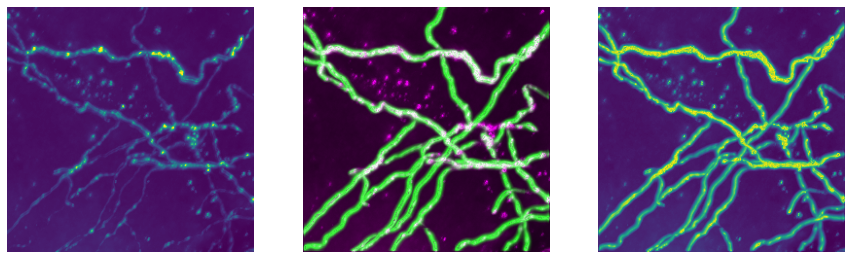

In [42]:
plt.figure(figsize=(15, 15))

# loop through the length of tickers and keep track of index
for n, pre in enumerate(predss):
    # add a new subplot iteratively
    ax = plt.subplot(1, 3, n + 1)

    # filter df and plot ticker on the new subplot axis
    plt.imshow(pre.max(2))

    # chart formatting
    plt.axis('off')

In [48]:
im1, pred1 = create_grayscale_plot(brain_i, cube_i)
im2, pred2 = create_grayscale_plot(brain_i, [17, 34, 1])
im3, pred3 = create_grayscale_plot(brain_i, [23, 34, 1])


In [49]:
predss = []
predss.append(im1)
predss.append(pred1)
predss.append(im2)
predss.append(pred2)
predss.append(im3)
predss.append(pred3)

len(predss)

6

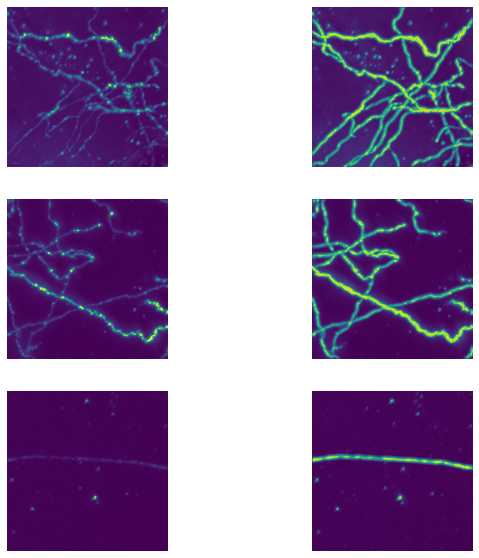

In [50]:
plt.figure(figsize=(10, 10))

# loop through the length of tickers and keep track of index
for n, pre in enumerate(predss):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)

    # filter df and plot ticker on the new subplot axis
    plt.imshow(pre)

    # chart formatting
    plt.axis('off')